In [1]:
import os
import json
from utils.vocabulary import *

import os
import json
from utils.vocabulary import *

data = "civil"
root_dir = f"/scratch/yifwang/fairness_x_explainability/encoder_results_{data}"
models = ["bert"] # ["bert", "roberta", "distilbert"]
bias_types = ["race", "gender", "religion"]
debiasing_methods = ["no_debiasing", "group_balance", "group_class_balance", "cda", "dropout", "attention_entropy", "causal_debias"]

training_types = ["all axes", "one axis"]
if data == "civil":
    num_examples = {"race": 2000, "gender": 2000, "religion": 1000}
elif data == "jigsaw":
    num_examples = {"race": 400, "gender": 800, "religion": 200}
fairness_metrics = ["accuracy", "f1", "fpr", "fnr", "individual_fairness"]


methods = ["Attention", "Saliency", "DeepLift", "InputXGradient", "IntegratedGradients", "Occlusion", "KernelShap"]
reliance_keys = ["raw"]


In [2]:
correlation_dict = {"model": [], "bias_type": [], "debiasing_method": [], "training_data": [], "explanation_method": [], "correlation": [], "reliance_method": []}
for model in models:
    for bias_type in bias_types:
        for training_type in training_types:
            data_token = "all" if training_type == "all axes" else bias_type
            for debiasing_method in debiasing_methods:
                for explanation_method in methods:
                    file_path = os.path.join(root_dir, f"{model}_{data}_{data_token}_{bias_type}_test_{num_examples[bias_type]}", debiasing_method, "correlation", f"correlation_{explanation_method}_{bias_type}_test.json")
                    if not os.path.exists(file_path):
                        print(f"File not found: {file_path}")
                        continue
                    with open(file_path, "r") as f:
                        correlation_data = json.load(f)
                    for aggregation_method, value in correlation_data.items():
                        for reliance_method in reliance_keys:
                            correlation_dict["model"].append(model)
                            correlation_dict["bias_type"].append(bias_type)
                            correlation_dict["debiasing_method"].append(debiasing_method)
                            correlation_dict["training_data"].append(training_type)
                            correlation_dict["explanation_method"].append(aggregation_method)
                            correlation_dict["correlation"].append(value['abs_average'][reliance_method])
                            correlation_dict["reliance_method"].append(reliance_method)
                    


In [3]:
# convert to a pandas DataFrame
import pandas as pd
correlation_df = pd.DataFrame(correlation_dict)
correlation_df

,model,bias_type,debiasing_method,training_data,explanation_method,correlation,reliance_method
0,bert,race,no_debiasing,all axes,raw_attention,0.363984,raw
1,bert,race,no_debiasing,all axes,attention_rollout,0.327635,raw
2,bert,race,no_debiasing,all axes,attention_flow,0.270487,raw
3,bert,race,no_debiasing,all axes,Saliency_L2,0.537509,raw
4,bert,race,no_debiasing,all axes,Saliency_mean,0.158240,raw
...,...,...,...,...,...,...,...
583,bert,religion,causal_debias,one axis,IntegratedGradients_L2,0.516379,raw
584,bert,religion,causal_debias,one axis,IntegratedGradients_mean,0.380547,raw
585,bert,religion,causal_debias,one axis,Occlusion,0.557856,raw
586,bert,religion,causal_debias,one axis,Occlusion_abs,0.574778,raw


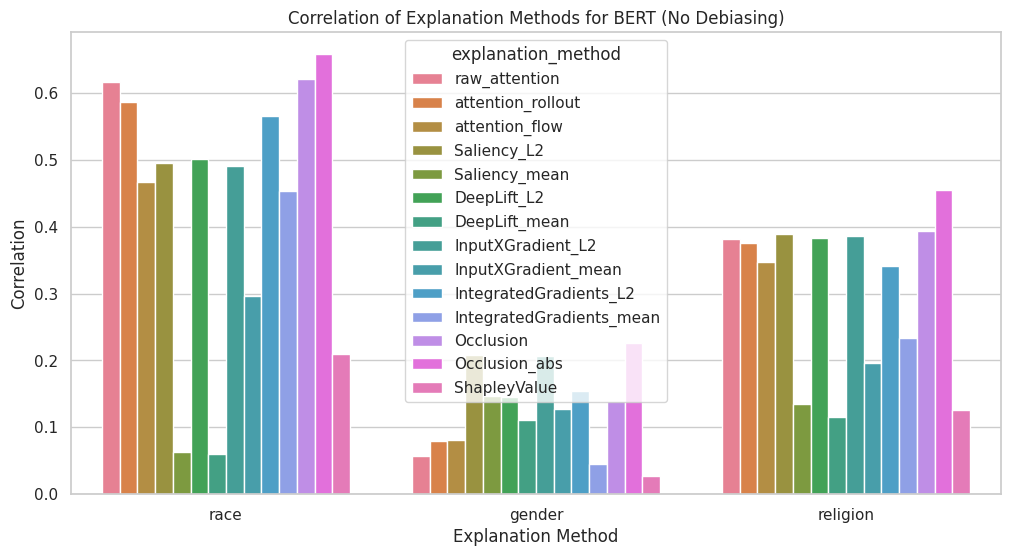

In [ ]:
# visualize
import seaborn as sns
import matplotlib.pyplot as plt

train_data = "one axis"
# use a bar plot visualize the correlation of each explanation method for bert, no_debiasing
# three bias types are placed next to each other
# bias type is x, explanation methods are indicated by colors
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(x="bias_type", y="correlation", hue="explanation_method", data=correlation_df[(correlation_df['model'] == "bert") & (correlation_df['debiasing_method'] == "no_debiasing") & (correlation_df["training_data"]==train_data)])
plt.title("Correlation of Explanation Methods for BERT (No Debiasing)")
plt.xlabel("Explanation Method")
plt.ylabel("Correlation")
plt.legend(title="Bias Type")
plt.show()

In [1]:
# visualize 4 debiasing methods and place them side by side in 4 sub-plots

reported_methods = ["no_debiasing", "group_balance", "cda", "causal_debias"]
rename_methods = {"no_debiasing": "Default",
                    "group_balance": "Group balance",
                    "cda": "CDA",
                    "causal_debias": "Causal debias",
                    }
fig, axes = plt.subplots(3, 4, figsize=(24, 8), sharey=True)
plt.subplots_adjust(hspace=0.6, wspace=0.1)
reported_methods = ["no_debiasing", "group_balance", "cda", "causal_debias"]

for i, method in enumerate(reported_methods):
    ax = axes[0][i]
    sns.barplot(
        x="bias_type",
        y="correlation",
        hue="explanation_method",
        data=correlation_df[
            (correlation_df['model'] == "bert") &
            (correlation_df['debiasing_method'] == method) &
            (correlation_df["training_data"] == "one axis")
        ],
        ax=ax
    )
    ax.set_title(rename_methods[method])
    ax.set_xlabel("")
    ax.set_ylabel("Correlation" if i == 0 else "")
    ax.get_legend().remove()  # Remove legend from subplot

for i, method in enumerate(reported_methods):
    ax = axes[1][i]
    sns.barplot(
        x="bias_type",
        y="correlation",
        hue="explanation_method",
        data=correlation_df[
            (correlation_df['model'] == "bert") &
            (correlation_df['debiasing_method'] == method) &
            (correlation_df["training_data"] == "all axes")
        ],
        ax=ax
    )
    ax.set_title(rename_methods[method])
    ax.set_xlabel("")
    ax.set_ylabel("Correlation" if i == 0 else "")
    ax.get_legend().remove()  # Remove legend from subplot

# Add row titles
row_titles = ["BERT (single)", "BERT (all)", "Qwen3"]

for row_idx, row_title in enumerate(row_titles):
    # Take the first axis in this row
    first_ax = axes[row_idx, 0]
    # Get bounding box of the whole row (all axes in this row)
    row_tops = [ax.get_position().y1 for ax in axes[row_idx, :]]
    row_top = max(row_tops)   # top y of the row
    # Place title centered above the row
    fig.text(
        0.5, row_top + 0.04,   # 0.02 is a small consistent padding
        row_title,
        ha="center", va="bottom", fontsize=14,
    )

# create space for legends, not using tight_layout
# leave extra room on the right for a global legend
fig.subplots_adjust(right=0.85,)

# Collect legend handles/labels
handles, labels = axes[0][0].get_legend_handles_labels()
# refresh the shared legend (keeps it aligned to the right)
fig.legend(handles, labels, title="Explanation Methods", loc='center right', bbox_to_anchor=(0.97, 0.5))
# plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make space for legend
plt.show()



KeyboardInterrupt

